In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
# %cd "/content/drive/MyDrive/tobigs/hanbok/styletransfer"
# !mkdir input
# !mkdir output

In [3]:
# !git clone https://github.com/levindabhi/cloth-segmentation.git
# %cd /content/drive/MyDrive/tobigs/hanbok/styletransfer/cloth-segmentation
# !mkdir input_images
# !mkdir output_images

In [4]:
%cd /content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/cloth-segmentation
import os
# from tqdm import tqdm
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

from data.base_dataset import Normalize_image
from utils.saving_utils import load_checkpoint_mgpu

from networks import U2NET
device = 'cpu'

image_dir = '/content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/input/'
result_dir = '/content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/output/'
checkpoint_path = '/content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/cloth-segmentation/cloth_segm_u2net_latest.pth'

def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return palette


transforms_list = []
transforms_list += [transforms.ToTensor()]
transforms_list += [Normalize_image(0.5, 0.5)]
transform_rgb = transforms.Compose(transforms_list)

net = U2NET(in_ch=3, out_ch=4)
net = load_checkpoint_mgpu(net, checkpoint_path)
net = net.to(device)
net = net.eval()

palette = get_palette(4)

!rm -rf '/content/drive/MyDrive/tobigs/hanbok/styletransfer/input/.ipynb_checkpoints'
images_list = sorted(os.listdir(image_dir))
print(images_list)
pbar = tqdm(total=len(images_list))
def getSegmented_image():
  ret = []
  for image_name in images_list:
      img = Image.open(os.path.join(image_dir, image_name)).convert('RGB')
      img_size = img.size
      img = img.resize((768, 768), Image.BICUBIC)
      image_tensor = transform_rgb(img)
      image_tensor = torch.unsqueeze(image_tensor, 0)
      # A X 1 X B X 1 X C X 1 = A X B X C
      output_tensor = net(image_tensor.to(device))
      # print(output_tensor)
      # output_tensor = F.log_softmax(output_tensor[0], dim=1)
      print(output_tensor[0].shape,"1")
      output_tensor = torch.max(output_tensor[0], dim=1, keepdim=True)[1]
      print(output_tensor.shape,"2")
      output_tensor = torch.squeeze(output_tensor, dim=0)
      print(output_tensor.shape,"3")
      output_tensor = torch.squeeze(output_tensor, dim=0)
      print(output_tensor.shape,"4")
      output_arr = output_tensor.cpu().numpy()

      output_img = Image.fromarray(output_arr.astype('uint8'), mode='L')
      output_img = output_img.resize(img_size, Image.BICUBIC)
      output_img_before = Image.fromarray(output_arr.astype('uint8')*255, mode='L')
      # output_img_before.save(os.path.join(result_dir, image_name[:-4]+'_before.png'))

      output_img.putpalette(palette)
      output_img.save(os.path.join(result_dir, image_name[:-4]+'_segmented.png'))
      ret.append(output_img)
      print(image_name)
      pbar.update(1)
  return ret
# getSegmented_image()
pbar.close()

/content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/cloth-segmentation
----checkpoints loaded from path: /content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/cloth-segmentation/cloth_segm_u2net_latest.pth----
['hanbok_wear.jpeg']


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [6]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [7]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [8]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [9]:
def imshow(image, title=None):
  if len(image.shape or image.size) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
def imshow_pil(image, title=None):
  if len(image.size) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [10]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [11]:
content_image = load_img("/content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/input/hanbok_wear.jpeg")
style_image = load_img("/content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/style/pattern5.jpg")
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
stylized_image = tensor_to_image(stylized_image)

In [12]:
%cd /content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/U-2-Net
# U-2-Net -> Saliency
# U-2-Net only segmentation -> Segmentation

import os
from skimage import io, transform
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms#, utils
# import torch.optim as optim

import numpy as np
from PIL import Image
import glob

from data_loader import RescaleT
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset

from model import U2NET # full size version 173.6 MB
from model import U2NETP # small version u2net 4.7 MB

# normalize the predicted SOD probability map
def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)

    dn = (d-mi)/(ma-mi)

    return dn

def save_output(image_name,pred,d_dir):

    predict = pred
    predict = predict.squeeze()
    predict_np = predict.cpu().data.numpy()

    im = Image.fromarray(predict_np*255).convert('RGB')
    img_name = image_name.split(os.sep)[-1]
    image = io.imread(image_name)
    imo = im.resize((image.shape[1],image.shape[0]),resample=Image.BILINEAR)

    pb_np = np.array(imo)

    aaa = img_name.split(".")
    bbb = aaa[0:-1]
    imidx = bbb[0]
    for i in range(1,len(bbb)):
        imidx = imidx + "." + bbb[i]

    imo.save(d_dir+imidx+'_saliency.png')
    return imo

def get_saliency_maps_name(image_name):

    # --------- 1. get image path and name ---------
    model_name='u2net'#u2netp



    image_dir =  '/content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/input'
    prediction_dir =  '/content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/output/'
    model_dir = os.path.join(os.getcwd(), 'saved_models', model_name, model_name + '.pth')
    print(os.getcwd())
    img_name_list = glob.glob(image_dir + os.sep + '*')
    print(img_name_list)

    # --------- 2. dataloader ---------
    #1. dataloader
    test_salobj_dataset = SalObjDataset(img_name_list = img_name_list,
                                        lbl_name_list = [],
                                        transform=transforms.Compose([RescaleT(320),
                                                                      ToTensorLab(flag=0)])
                                        )
    test_salobj_dataloader = DataLoader(test_salobj_dataset,
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=1)

    # --------- 3. model define ---------
    if(model_name=='u2net'):
        print("...load U2NET---173.6 MB")
        net = U2NET(3,1)
    elif(model_name=='u2netp'):
        print("...load U2NEP---4.7 MB")
        net = U2NETP(3,1)

    if torch.cuda.is_available():
        net.load_state_dict(torch.load(model_dir))
        net.cuda()
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()

    # --------- 4. inference for each image ---------
    ret = []
    for i_test, data_test in enumerate(test_salobj_dataloader):
        if(img_name_list[i_test].split(os.sep)[-1]==image_name):

          print("inferencing:",img_name_list[i_test].split(os.sep)[-1])

          inputs_test = data_test['image']
          inputs_test = inputs_test.type(torch.FloatTensor)

          if torch.cuda.is_available():
              inputs_test = Variable(inputs_test.cuda())
          else:
              inputs_test = Variable(inputs_test)

          d1,d2,d3,d4,d5,d6,d7= net(inputs_test)

          # normalization
          pred = d1[:,0,:,:]
          pred = normPRED(pred)

          # save results to test_results folder
          if not os.path.exists(prediction_dir):
              os.makedirs(prediction_dir, exist_ok=True)
          img = save_output(img_name_list[i_test],pred,prediction_dir)
          ret.append(img)
          del d1,d2,d3,d4,d5,d6,d7
    return ret
def get_saliency_maps():

    # --------- 1. get image path and name ---------
    model_name='u2net'#u2netp



    image_dir =  '/content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/input'
    prediction_dir =  '/content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/output/'
    model_dir = os.path.join(os.getcwd(), 'saved_models', model_name, model_name + '.pth')
    print(os.getcwd())
    img_name_list = glob.glob(image_dir + os.sep + '*')
    print(img_name_list)

    # --------- 2. dataloader ---------
    #1. dataloader
    test_salobj_dataset = SalObjDataset(img_name_list = img_name_list,
                                        lbl_name_list = [],
                                        transform=transforms.Compose([RescaleT(320),
                                                                      ToTensorLab(flag=0)])
                                        )
    test_salobj_dataloader = DataLoader(test_salobj_dataset,
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=1)

    # --------- 3. model define ---------
    if(model_name=='u2net'):
        print("...load U2NET---173.6 MB")
        net = U2NET(3,1)
    elif(model_name=='u2netp'):
        print("...load U2NEP---4.7 MB")
        net = U2NETP(3,1)

    if torch.cuda.is_available():
        net.load_state_dict(torch.load(model_dir))
        net.cuda()
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()

    # --------- 4. inference for each image ---------
    ret = []
    for i_test, data_test in enumerate(test_salobj_dataloader):
        

        print("inferencing:",img_name_list[i_test].split(os.sep)[-1])

        inputs_test = data_test['image']
        inputs_test = inputs_test.type(torch.FloatTensor)

        if torch.cuda.is_available():
            inputs_test = Variable(inputs_test.cuda())
        else:
            inputs_test = Variable(inputs_test)

        d1,d2,d3,d4,d5,d6,d7= net(inputs_test)

        # normalization
        pred = d1[:,0,:,:]
        pred = normPRED(pred)

        # save results to test_results folder
        if not os.path.exists(prediction_dir):
            os.makedirs(prediction_dir, exist_ok=True)
        img = save_output(img_name_list[i_test],pred,prediction_dir)
        ret.append(img)
        del d1,d2,d3,d4,d5,d6,d7
    return ret

/content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/U-2-Net


In [13]:
%cd /content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/cloth-segmentation
segmented_images = getSegmented_image()
len(segmented_images)
%cd /content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/U-2-Net
saliency_maps = get_saliency_maps()

/content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/cloth-segmentation


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


torch.Size([1, 4, 768, 768]) 1
torch.Size([1, 1, 768, 768]) 2
torch.Size([1, 768, 768]) 3
torch.Size([768, 768]) 4
hanbok_wear.jpeg
/content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/U-2-Net
/content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/U-2-Net
['/content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/input/hanbok_wear.jpeg']
...load U2NET---173.6 MB
inferencing: hanbok_wear.jpeg


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [14]:
stylized_images = []

style_image_path  = "/content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/style/pattern5.jpg" #@param {type:"string"}
style_image = load_img(style_image_path)

content_Image_path = "/content/drive/MyDrive/tobigs_hanbok/준보/hanbok/styletransfer/input/"#@param {type:"string"}
reuse_old_image = True #@param {type:"boolean"}
for i in range(len(saliency_maps)):
  content = load_img(content_Image_path+images_list[i])
  stylized = hub_model(tf.constant(content), tf.constant(style_image))[0]
  stylized = tensor_to_image(stylized)
  stylized_images.append(stylized)
  saliency_maps[i] = saliency_maps[i].resize((stylized.size[0],stylized.size[1]),Image.BICUBIC)
  segmented_images[i] = segmented_images[i].resize((stylized.size[0],stylized.size[1]),Image.BICUBIC)
# if(not(reuse_old_image)):
  inputs_img = []
  inputs_img2 = []
  for i in range(len(images_list)):
    img = Image.open(os.path.join(image_dir, images_list[i])).convert('RGB')
    img2 = Image.open(os.path.join(image_dir, images_list[i])).convert('RGB')
    img = img.resize((stylized_images[i].size[0],stylized_images[i].size[1]),Image.BICUBIC)
    inputs_img.append(img)
    inputs_img2.append(img2)
for i in range(len(segmented_images)):
  segmented_images[i] = segmented_images[i].convert('RGB')

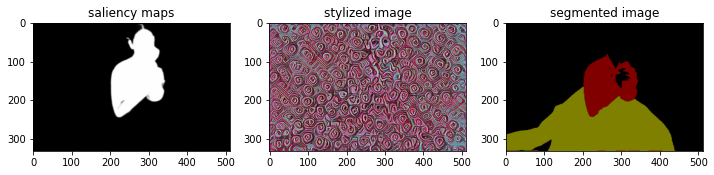

In [15]:
plt.subplot(1, 3, 1)
imshow_pil(saliency_maps[0],"saliency maps")
plt.subplot(1, 3, 2)
imshow_pil(stylized_images[0],"stylized image")
plt.subplot(1, 3, 3)
imshow_pil(segmented_images[0],"segmented image")

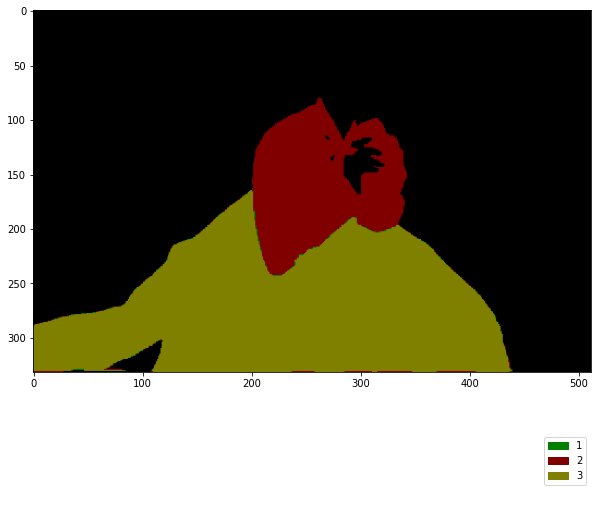

In [16]:
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
na = np.array(segmented_images[0].convert('RGB'))
colours, counts = np.unique(na.reshape(-1,3), axis=0, return_counts=1)
# print(colours)
gs = GridSpec(6,1)

fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(gs[:-1,:]) ##for the plot
ax2 = fig.add_subplot(gs[-1,:]) 
legend_data = []
# print(colours)
ax1.imshow(segmented_images[0])
for i in range(len(colours)):
  if(colours[i][0]==0 and colours[i][1]==0 and colours[i][2]==0):
    continue
  temp = [0,colours[i],i]
  legend_data.append(temp)

handles = [
    Rectangle((0,0),1,1, color = tuple((v/255 for v in c))) for k,c,n in legend_data
]
labels = [n for k,c,n in legend_data]
ax2.legend(handles,labels, mode='expand', ncol=3)
ax2.axis('off')

plt.legend(handles,labels)
plt.show()

In [22]:
chosen_segment =  2

In [23]:
ctr =0
segmented_styled = []
for i in range(len(segmented_images)):
  newImage = segmented_images[i].copy()
  pix_seg = segmented_images[i].load()
  pix_sty = stylized_images[i].load()
  
  pix_seg_sty = newImage.load()
  for x in range((segmented_images[i].size[0])):
    for y in range((segmented_images[i].size[1])):
      if(pix_seg[x,y]==(colours[chosen_segment][0],colours[chosen_segment][1],colours[chosen_segment][2])):
        # print(pix_sty[x,y])
        # print((pix_seg[x,y]))
        pix_seg_sty[x,y] = pix_sty[x,y]

        # break
  segmented_styled.append(newImage)

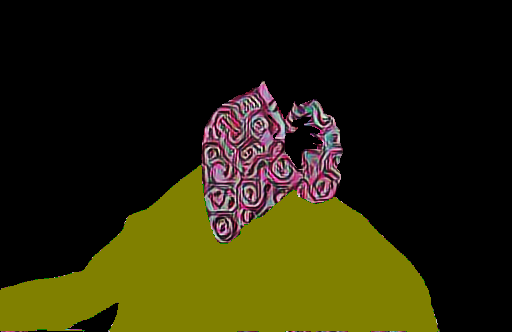

In [24]:
segmented_styled[0]

In [25]:
import colorsys

res = []
import copy
for i in range(len(segmented_images)):
  pix_unstyled = segmented_images[i].load()
  pix_seg = segmented_styled[i].load()
  pix_saliency = saliency_maps[i].convert(mode='L').load()
  pix_sty = stylized_images[i].load()
  pix_inp = inputs_img[i].load()
  newImage = copy.deepcopy(inputs_img[i])
  lum_image = copy.deepcopy(inputs_img[i])
  pix_lum = lum_image.convert(mode="L").load()
  # environment = brightness(inputs_img[i])
  pix_nimg = newImage.load()
  for x in range((segmented_images[i].size[0])):
    for y in range((segmented_images[i].size[1])):
      if(pix_unstyled[x,y]==(colours[chosen_segment][0],colours[chosen_segment][1],colours[chosen_segment][2])):
        # temp = colorsys.rgb_to_hsv(pix_seg[x,y][0]/255, pix_seg[x,y][1]/255, pix_seg[x,y][2]/255)
        # temp2 = colorsys.rgb_to_hsv(pix_inp[x,y][0]/255, pix_inp[x,y][1]/255, pix_inp[x,y][2]/255)
        # # print(temp2[2])
        # final = colorsys.hsv_to_rgb(temp[0], temp[1], temp2[2])
        # print(pix_saliency[x,y])
        # pix_nimg[x,y] = tuple(int(i) for i in pix_seg[x,y])
        if(pix_saliency[x,y]==255):
          pix_nimg[x,y] = tuple(int(i) for i in pix_seg[x,y])
        else:
          saliency_binary_val = (pix_saliency[x,y]/255)
          final = tuple((saliency_binary_val*pix_seg[x,y][i] + (1-saliency_binary_val)*pix_inp[x,y][i]) for i in range(3))
          # print(final)
        # print(pix_seg[x,y], final)                           
          pix_inp[x,y] = tuple(int(i) for i in final)
        
        # print(pix_nimg[x,y])
  # newImage = newImage.convert('RGB')
  res.append(newImage)

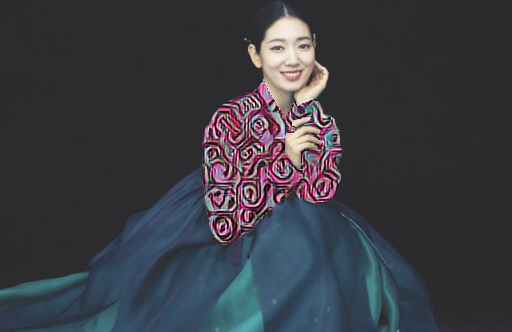

In [26]:
inputs_img[0]